In [120]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torch.utils
from torchvision import transforms

from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid


In [121]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_data = torchvision.datasets.MNIST(root='data', train=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='data', train=False, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [122]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

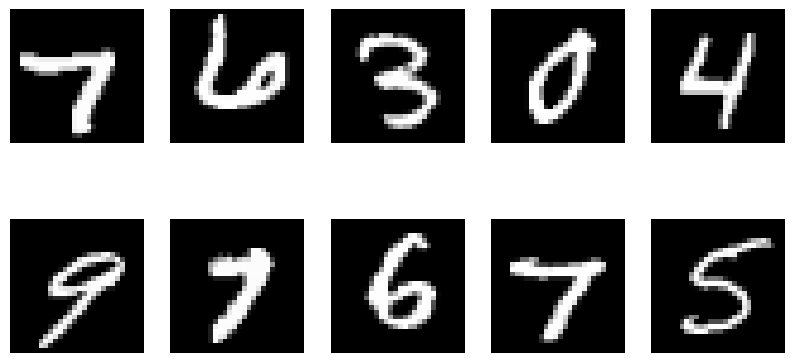

In [123]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

In [124]:
images.shape

torch.Size([32, 1, 28, 28])

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, coding_size=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),  # Flatten input images to 784
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.mu = nn.Linear(16, coding_size)
        self.logvar = nn.Linear(16, coding_size)

        self.decoder = nn.Sequential(
            nn.Linear(coding_size, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 28 * 28),
            nn.Sigmoid()
        )

    def sampling(self, mu, logvar): 
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)  # Sample from a standard normal distribution
        return mu + eps * std  # Return the reparameterized sample
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input (batch size, 784)
        x = self.encoder(x)
        mu = self.mu(x)  # Get mean
        logvar = self.logvar(x)  # Get log variance
        z = self.sampling(mu, logvar)  # Sample from latent space
        recon_x = self.decoder(z)  # Decode the latent variable
        return recon_x.view(-1, 1, 28, 28), mu, logvar  # Reshape output back to (batch_size, 1, 28, 28)


In [126]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience

    def step(self, loss):
        if self.loss > loss:
            self.loss
            self.patience = 0
        else:
            patiece += 1

    def is_stop(self):
        return self.patience >= self.patience_limit



In [127]:
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction Loss (assuming Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')

    # KL Divergence Loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [128]:
num_epochs = 20

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()  # Clear the gradients
        recon_batch, mu, logvar = vae(data)  # Forward pass
        loss = vae_loss(recon_batch, data, mu, logvar)  # Calculate loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}')

Epoch 1, Loss: 0.0848
Epoch 2, Loss: 0.0811
Epoch 3, Loss: 0.0729
Epoch 4, Loss: 0.0779
Epoch 5, Loss: 0.0706
Epoch 6, Loss: 0.0804
Epoch 7, Loss: 0.0768
Epoch 8, Loss: 0.0762
Epoch 9, Loss: 0.0734
Epoch 10, Loss: 0.0732
Epoch 11, Loss: 0.0696
Epoch 12, Loss: 0.0783
Epoch 13, Loss: 0.0737
Epoch 14, Loss: 0.0806
Epoch 15, Loss: 0.0716
Epoch 16, Loss: 0.0742
Epoch 17, Loss: 0.0696
Epoch 18, Loss: 0.0754
Epoch 19, Loss: 0.0730
Epoch 20, Loss: 0.0720


In [134]:
model_save_path = 'models/vae.pth'

# Save the model's state dictionary
torch.save(vae.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to models/vae.pth


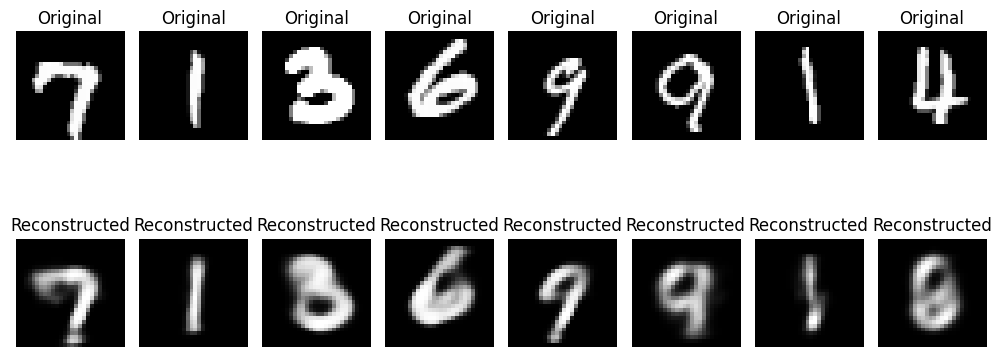

In [129]:
import torch
import matplotlib.pyplot as plt

# Set to evaluation mode for reconstruction
vae.eval()

# Assuming `test_loader` is already defined and contains your test dataset
with torch.no_grad():  # Disable gradient calculation for predictions
    for data, _ in test_loader:  # Iterate over the test data
        data = data.to(device)  # Move data to GPU if available
        recon_batch, mu, logvar = vae(data)  # Forward pass

        # Number of images to display
        n = min(data.size(0), 8)  # Display up to 8 images

        # Create subplots
        plt.figure(figsize=(10, 5))
        for i in range(n):
            # Original images
            plt.subplot(2, n, i + 1)  # 2 rows, n columns, position i+1
            plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray')  # Show original image
            plt.axis('off')  # Hide the axes
            plt.title("Original")

            # Reconstructed images
            plt.subplot(2, n, i + 1 + n)  # 2 rows, n columns, position i+1+n
            plt.imshow(recon_batch[i].cpu().numpy().squeeze(), cmap='gray')  # Show reconstructed image
            plt.axis('off')  # Hide the axes
            plt.title("Reconstructed")

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()
        
        break  # Only show the first batch for brevity


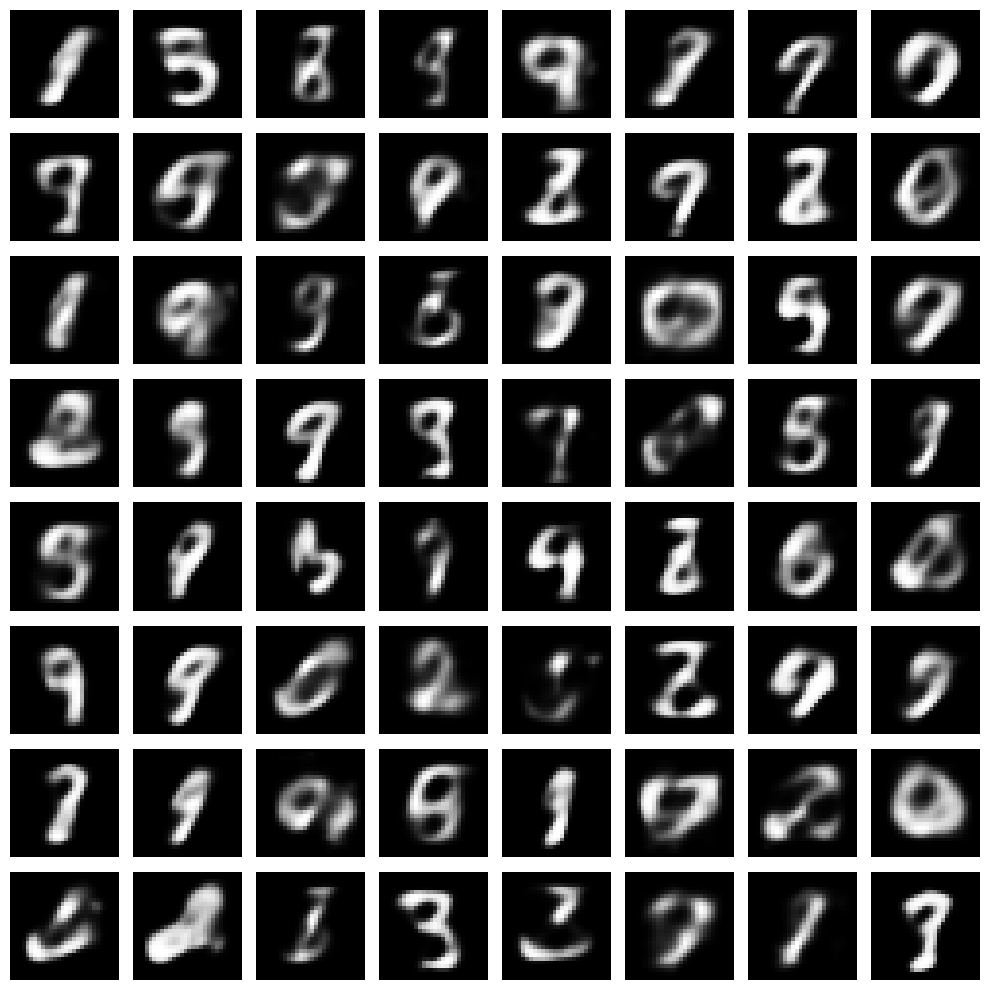

In [130]:
import torch
import matplotlib.pyplot as plt

# Generate new samples
with torch.no_grad():
    # Sample random latent vectors
    z = torch.randn(64, 32).to(device)  # Adjust the shape according to coding_size 32
    generated_images = vae.decoder(z)  # Decode to generate images

    # Visualize generated images in a subplot layout
    n = 8  # Number of images to display in each row
    plt.figure(figsize=(10, 10))

    for i in range(n * n):  # Create a grid of n x n images
        plt.subplot(n, n, i + 1)  # Create a subplot for each image
        plt.imshow(generated_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Reshape to 28x28
        plt.axis('off')  # Hide the axes

    plt.tight_layout()  # Adjust layout
    plt.show()
